### Ejercicio   2. 
Entrená   un   modelo   que   clasifique   correctamente   las   clases   en   el   archivo “6_clases_dificil.csv”. Realizá un análisis de las diferentes métricas vistas en clase. Podés utilizar las funciones  definidas  en AAPutils.pypara  realizar  más  rápidamentelos  gráficos  y  reportes. de utilidad

- separar en train-test
- curvas de entrenamiento (basadas en loss y epochs) para test y train ( o validation )
X_train, X_test, Y_train, Y_test= AAPutils.dividir_train_test(X, Y, test_size= test_proportion)

- errores nos permite saber como se ajusta nuestro modelo a las probabilidades
AAPutils.plot_training_curves(history)

- matriz de confusión
AAPutils.plot_confusion_matrix(y_true, y_pred)

```
[[TN FP],[FN, TP]]
```

- accuracy:> TP + TN / N. No es una buena métrica si el modelo está desbalanceado
- precision:> TP / TP + FP ( que tan bien predije)
- recall : > TP / TP + FN (los que recordó)
- f-score: 2 * (precisio * recall) / (precision + recall) 

- para desbalanceados, podemos decirle el class_weight:> dict que indica el peso de cada clase (proporción). A medida que movemos el peso, se inclida el tradeoff precision-recall
- ROC: nos muestra como se comporta el modelo (binario) al cambiar el umbral de detección.
Usa TPR = Recall y FPR = 1 - TN / (TN + FP) = FP / (TN+FP)   
AAPutils.plot_ROC_curve(model, x, y)

- overfitting: muy complejo. bias error = 0 y variance error grande (no generaliza)
- underfitting: muy simple. bias error grande. Falta entrenar
- correcto: bias-variance tradeoff. Entrena y predice en en train, y en test un poco peor, pero bien. Graficar learning curve. y función error
A grandes rasgos, podríamos decir que empieza a overfittear cuando no mejora más el modelo en los datos no vistos (testing)

Regularización. Restringir la complejidad de un modelo. Evitar el overfitting. Penalización.




In [ ]:
import numpy as np
import tensorflow as tf
import keras
import numpy as np
import os
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import utils
import AAPutils
import pandas as pd
from sklearn import model_selection, metrics, preprocessing


Cargamos nuestro dataset, y lo dividimos en feature y target

In [219]:
df = pd.read_csv('./datasets/6_clases_dificil.csv')
df.columns = ["x1","x2", "target"]
df = df.astype('float')
X = df.loc[:,~df.columns.isin(['target'])].values
y = df['target'].values

# X = preprocessing.MinMaxScaler().fit_transform(X)

Separamos en nuestro dataset de train y test. 70/30 aprox

In [222]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.3, random_state=7)

Obtenemos la entrada (cantidad de features) y salida (multiclase, cantidad de clases

In [223]:
d_in = X.shape[1]
d_out = np.unique(y).size
classes = d_out

In [224]:
# verificamos los valores
d_in, d_out, X_train.shape, y_train.shape, X_test.shape, y_test.shape,

(2, 6, (1050, 2), (1050,), (450, 2), (450,))

Empezamos a realizar nuestro modelo. 
Topología: 
- Dense(200, relu)
- Dense(100, tanh)
- Dense(20, tanh)
    


In [225]:
layer1 = keras.layers.Dense(
    200, 
    input_shape=(d_in,), 
    activation='relu'
)

layer2 = keras.layers.Dense(
    100, 
    activation='tanh'
)

layer3 = keras.layers.Dense(
    20, 
    activation='tanh'
)

# https://en.wikipedia.org/wiki/Logit
# la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
output = keras.layers.Dense(classes, activation='softmax')

# Creo un modelo logístico
model = keras.Sequential()

layers = [
    layer1,
    layer2, 
    layer3,
    output
]

for l in layers:
    model.add(l)

# posibles optimizadores:
# https://keras.io/optimizers/
# 'adam'

alpha = 0.005
epochs = 700

model.compile(
  optimizer='adam', #keras.optimizers.SGD(lr=alpha), 
  loss='sparse_categorical_crossentropy', # error para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=[
      'accuracy', 
      #'sparse_categorical_accuracy'
  ], 
)

In [226]:
# Entrenamiento del modelo
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32, 
    verbose=0, 
#     initial_epoch=400,
    callbacks = [
        # https://stackoverflow.com/questions/43906048/keras-early-stopping
        # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
        # Early stopping callback is called on every epoch end, compares the best monitored value with the current one and stops if conditions are met
       keras.callbacks.callbacks.EarlyStopping(
           monitor='val_loss', 
#            min_delta=0, 
           patience=15,
           verbose=0, 
           mode='auto', 
           baseline=None, 
           restore_best_weights=True)
    ],
    validation_data = (X_test, y_test),
    class_weight = utils.calculate_class_weight(y_train) # acá va esto? o el de train?
)

In [227]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 200)               600       
_________________________________________________________________
dense_141 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_142 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_143 (Dense)            (None, 6)                 126       
Total params: 22,846
Trainable params: 22,846
Non-trainable params: 0
_________________________________________________________________


In [228]:
print(metrics.classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        76
         1.0       0.97      1.00      0.99        75
         2.0       0.97      0.94      0.95        88
         3.0       1.00      0.97      0.99        74
         4.0       1.00      1.00      1.00        75
         5.0       1.00      1.00      1.00        62

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [230]:
print(metrics.classification_report(y, model.predict_classes(X)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       250
         1.0       0.99      1.00      1.00       250
         2.0       0.99      0.98      0.98       250
         3.0       1.00      0.99      1.00       250
         4.0       1.00      1.00      1.00       250
         5.0       1.00      1.00      1.00       250

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



_______________
Mostramos la curva de aprendizaje para el error (entropia cruzada) y accuracy cada vez que el modelo mejora.

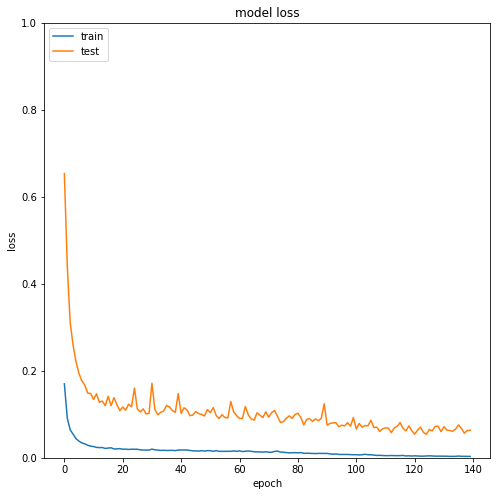

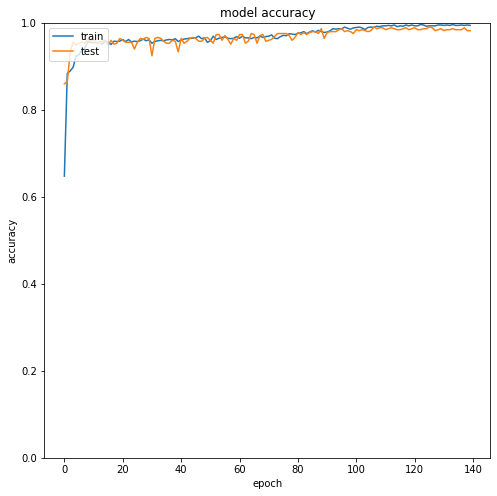

In [239]:
# todas las metricas tienen su nombre en metrics_names
# si hay (Xv, yv), entonces aparecen 2 métricas nuevas "val_mymetricname"

for k, i in zip(list(range(len(model.metrics_names))), model.metrics_names):
    plt.figure(figsize=(8,8))
    plt.ylim(0,1)
    utils.plot_curve(history, i)

## Conclusión:
- Llegamos a un 99% de accuracy con 3 capas. 
- Vemos que con los pasos de gradiente, el modelo oscila en loss de test bastante, aunque siempre baja. 
- Si quitamos el early-stopping, entrena más! pero no se si es necesario. 
- Hay un tradeoff entre el step del gradiente, la cantidad de épocas y EarlyStopping
    - si es muy chico el step, necesita más épocas para overfittear. 
    - Adam tenía mejor performance que sgd
    - EarlyStopping nos permite frenar cuando el modelo no mejora más (en testing)
- No usamos un scaler, pero el modelo entrenó bien en este caso. 
- habría que analizar si son muchas/pocas neuronas.

_______________________________________
### Anexo: otras utils


El modelo en keras puede evaluar las métricas aquí (en orden según metrics_names)

In [232]:
model.evaluate(X_test, y_test), model.evaluate(X_train, y_train)

1050/1050 [==============================] - 0s 74us/step


([0.0909677135750341, 0.9822221994400024], [0.001179094880908018, 1.0])

In [233]:
# se imprime en el reporte
metrics.f1_score(y_test, model.predict_classes(X_test), average='weighted')

0.9821765695090658

In [234]:
# se imprime en el reporte
metrics.accuracy_score(y_test, model.predict_classes(X_test))

0.9822222222222222

In [235]:
# se imprime en el reporte
print(metrics.precision_score(y_test, model.predict_classes(X_test), average='weighted'))

0.9823535637489127


In [236]:
# se imprime en el reporte
metrics.recall_score(y_test, model.predict_classes(X_test), average='weighted')

0.9822222222222222

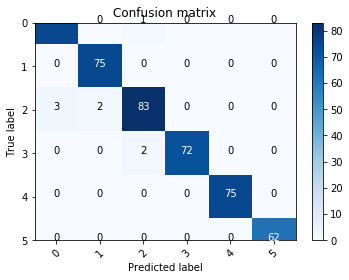

In [237]:
AAPutils.plot_confusion_matrix(y_test, model.predict_classes(X_test))

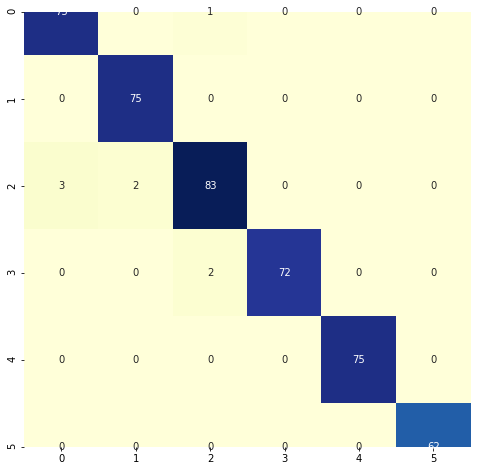

In [238]:
plt.figure(figsize=(8,8))

arr = pd.DataFrame(
    metrics.confusion_matrix(y_test, model.predict_classes(X_test)),
    index=list(range(classes)), 
    columns=list(range(classes))
)

sns.heatmap(arr, cmap='YlGnBu',annot=True,fmt="d", cbar=False)